<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter10/corwd_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crowd Counting
given an image with a crowd, we want to predict the number of people present in the image. 
The training images are taken from [ShanghaiTech dataset](https://github.com/desenzhou/ShanghaiTechDataset).  
a sample of input image and the location of the center of the heads is as follows:  
![img1](Ch10_1.png)  


Its hard to see, but the right image has exactly N white pixels corresponding to the location of the center of the heads. 
to see it better, lets look at a zoomin :  
![img2](Ch10_2.png)

we need to transform the ground truth sparse image into a density map that represents the number of people in that region:  
![img3](Ch10_3.png)

So the final input-output pair of the crop looks like that:  
![img4](Ch10_4.png)  

and for the whole image:
![img4a](Ch10_4a.png)  


Essentially, the heatmap is generated in such a way that the sum of the pixel values is equal to the number of people present in the image.

## Loading model and data
we will leverage the architecture detailed in the paper [*CSRNet: Dilated Convolutional Neural Networks for Understanding the Highly Congested Scenes*](https://arxiv.org/pdf/1802.10062.pdf)  
The model architecture is as follows:  
![Ch10_5](Ch10_5.png)  

we are passing the image through four additional layers of convolutions after first passing it through the standard VGG-16 backbone. 
This output is passed through one of the four configurations and finally through a 1 x 1 x 1 convolution layer. We will be using the A configuration as it is the smallest.


### Loss
Next, we perform Mean Squared Error (MSE) loss minimization on the output image to arrive at the optimal weight values while keeping track of the actual crowd count using MAE


### Dilated conv
the authors used dilated convolution instead of normal convolution. A typical dilated convolution looks as follows: ( [image source](https://arxiv.org/pdf/1802.10062.pdf) )  
![img6](Ch10_6.png)  

the diagram on the left represents a typical kernel that we have been working on so far. The second and third diagrams represent the dilated kernels, which have a gap between individual pixels. This way, the kernel has a larger receptive field. A large receptive field can come in handy as we need to understand the number of people near to a given person in order to estimate the pixel density corresponding to the person. We are using a dilated kernel (of nine parameters) instead of a normal kernel (which will have 49 parameters to be equivalent to a dilation rate of three kernels) to capture more information with fewer parameters.


## Code overview
The flow:
1. import relevant packages and dataset
2. the dataset already has the center of faces converted to a distribution based on Gaussian filter density, se we need not perform it again. 
3. define a function for dilated convolution
4. define the network model and train on batches of data to minimize the MSE



In [6]:
%%time
import os
if not os.path.exists('CSRNet-pytorch/'):
    # !pip install -U scipy torch_snippets torch_summary
    # !git clone https://github.com/sizhky/CSRNet-pytorch.git
    # from google.colab import files
    # files.upload() # upload kaggle.json
    # !mkdir -p ~/.kaggle
    # !mv kaggle.json ~/.kaggle/
    # !ls ~/.kaggle
    # !chmod 600 /root/.kaggle/kaggle.json
    # print('downloading data...')
    # !kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
    # print('unzipping data...')
    # !unzip -qq shanghaitech-with-people-density-map.zip
    pass

# %cd CSRNet-pytorch
# !ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

CPU times: user 18.4 ms, sys: 4.23 ms, total: 22.6 ms
Wall time: 24.4 ms


In [15]:
dataset_path = os.path.expanduser('~/datasets/shanghaitech_with_people_density_map/ShanghaiTech/part_A/')

part_A = Glob(os.path.join(dataset_path,'train_data/'))

# image_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
# heatmap_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
# gt_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

image_folder = os.path.join(dataset_path,'train_data/images/')
heatmap_folder = os.path.join(dataset_path,'train_data/ground-truth-h5/')
gt_folder = os.path.join(dataset_path,'train_data/ground-truth/')

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'

        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [28]:
img1[0].shape

(683, 1024, 3)

Lets have a look at a sample image and its ground truth:

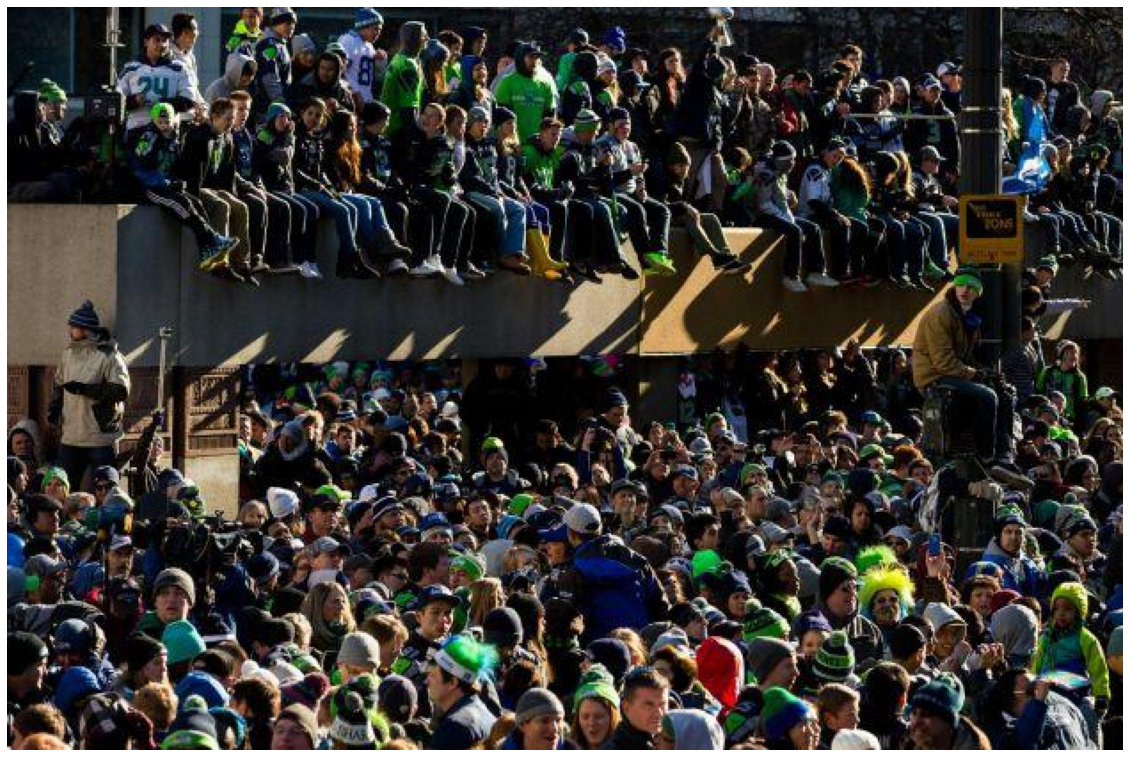

In [37]:
img1=trn_ds[100]
show(img1[0])

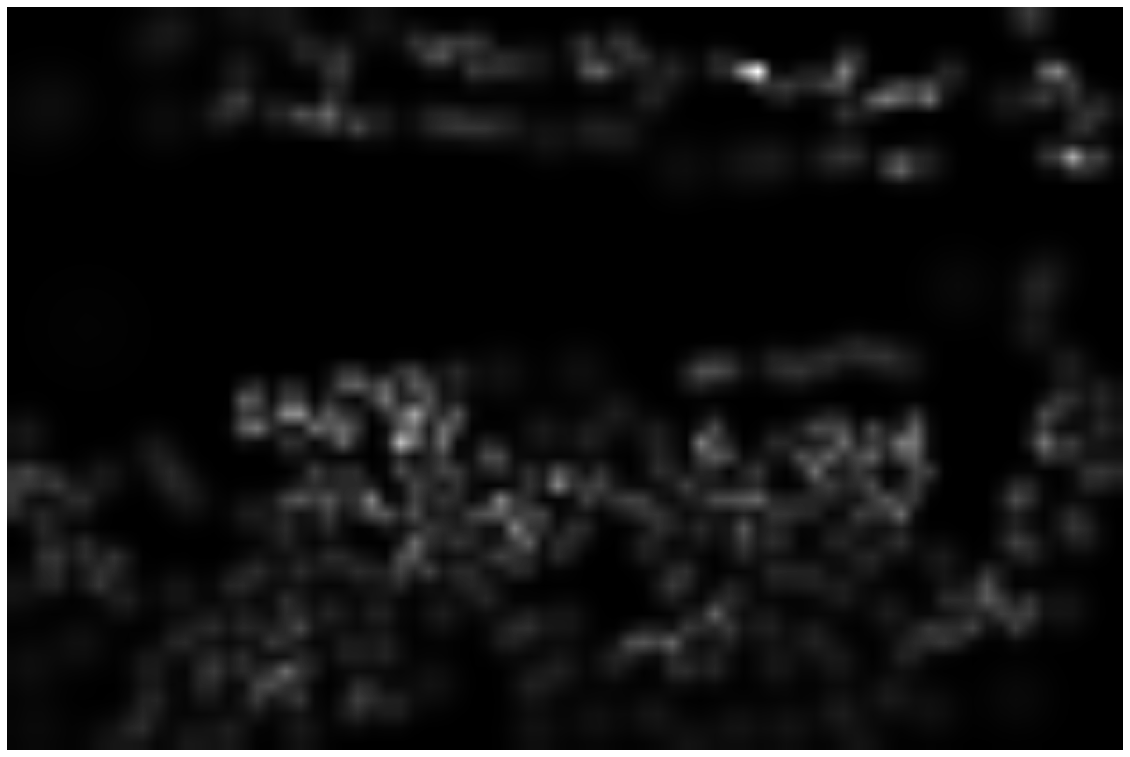

In [38]:
show(resize(img1[1],img1[0].shape[:2]))

In [39]:
img1[2]

336

In [41]:
%cd CSRNet-pytorch
!pwd

/home/guy/workspace/study/git/guyk1971/Modern-Computer-Vision-with-PyTorch/Ch10_Apps_Obj_Det_Seg/CSRNet-pytorch
/home/guy/workspace/study/git/guyk1971/Modern-Computer-Vision-with-PyTorch/Ch10_Apps_Obj_Det_Seg/CSRNet-pytorch


In [42]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [43]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [44]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [45]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.053	trn_pts_loss: 473.724	val_loss: 0.040	val_pts_loss: 268.029	(251.77s - 4783.67s remaining)
EPOCH: 2.000	trn_loss: 0.043	trn_pts_loss: 319.593	val_loss: 0.041	val_pts_loss: 330.917	(510.33s - 4592.98s remaining)
EPOCH: 3.000	trn_loss: 0.040	trn_pts_loss: 242.560	val_loss: 0.034	val_pts_loss: 179.269	(768.81s - 4356.57s remaining)
EPOCH: 4.000	trn_loss: 0.036	trn_pts_loss: 167.915	val_loss: 0.033	val_pts_loss: 137.617	(1027.32s - 4109.27s remaining)
EPOCH: 5.000	trn_loss: 0.035	trn_pts_loss: 162.159	val_loss: 0.031	val_pts_loss: 138.418	(1285.81s - 3857.43s remaining)
EPOCH: 6.000	trn_loss: 0.034	trn_pts_loss: 145.611	val_loss: 0.032	val_pts_loss: 136.100	(1544.31s - 3603.38s remaining)
EPOCH: 7.000	trn_loss: 0.034	trn_pts_loss: 140.234	val_loss: 0.033	val_pts_loss: 249.017	(1802.80s - 3348.05s remaining)
EPOCH: 8.000	trn_loss: 0.033	trn_pts_loss: 142.847	val_loss: 0.030	val_pts_loss: 120.810	(2061.27s - 3091.91s remaining)
EPOCH: 9.000	trn_loss: 0.033	trn_pt

In [47]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = os.path.join(dataset_path,'test_data/')
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)
img = transform(Image.open(f).convert('RGB')).to(device)

/home/guy/datasets/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_38.jpg


Predicted Count :  603


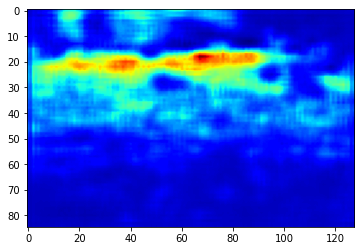

In [48]:
output = model(img[None])
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()